In [6]:
#Total Staked Tokens
import requests
import json

url = "https://cosmos-rest.publicnode.com/cosmos/staking/v1beta1/pool"

pool_info = requests.get(url)
pool_info = pool_info.json()
total_staked_tokens = pool_info['pool']['bonded_tokens']
print(total_staked_tokens)


231829954897746


In [11]:
import pandas as pandas

signing_data = pandas.read_csv('cosmos_validator_signing_data.csv')
slashing_params = pandas.read_csv("cosmos_slashing_params.csv")
mapped_data = pandas.read_csv("cosmos_validator_mapped_data.csv")

#Calculating missed blocks
signed_blocks_window = slashing_params["signed_blocks_window"].iloc[0]

signing_data["missed_blocks"] = (signing_data['missed_blocks_counter'] / signed_blocks_window) * 100

#block completeion rate
signing_data["block_completion_rate"] = ((signed_blocks_window - signing_data["missed_blocks_counter"]) / signed_blocks_window) * 100

#Staking Data

staking_size_mapping = dict(zip(mapped_data["Consensus Address"], mapped_data["Stake Size"]))
signing_data["Stake Size"] = signing_data["address"].map(staking_size_mapping)

# Calculate uptime percentage
signing_data["uptime_percentage"] = (
    (signed_blocks_window - signing_data["missed_blocks_counter"]) / signed_blocks_window
) * 100

# Calculate signed compliance
signing_data["signed_compliance"] = (
    signing_data["block_completion_rate"] - 
    (slashing_params["min_signed_per_window"].iloc[0] * 100)
)

#pseduo slashing feature: 

signing_data['dummy_slashed'] = signing_data['jailed_until'].apply(lambda x: 1 if x != '1970-01-01T00:00:00Z' else 0)


new_columns = [
    'address',
    'missed_blocks',
    'block_completion_rate',
    'Stake Size',
    'uptime_percentage',
    'signed_compliance',
    'dummy_slashed'

]

combined_df = signing_data[new_columns]
combined_df.to_csv("FeatureCreation.csv", index=False)

                                     




Test Accuracy: 0.5070422535211268
ROC-AUC Score: 0.6081081081081081


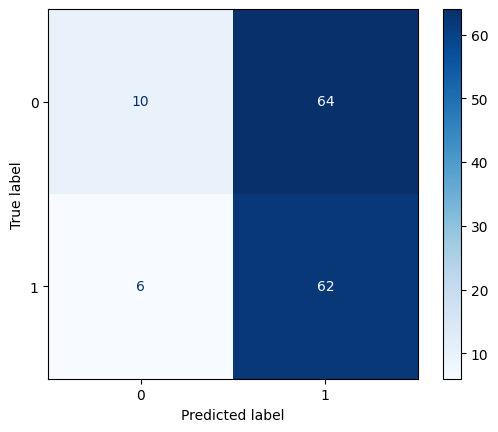

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

#Logistic Regression

dataset = pandas.read_csv("FeatureCreation.csv")

X = dataset.drop(columns=["dummy_slashed", "address"], axis=1)
y = dataset["dummy_slashed"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
# print("Classification Report:\n", classification_report(y_test, y_pred))  # if we are interested in metrics like precision and recall

# Calculate ROC-AUC for binary classification
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')

Expected Slashing Events: 77.606
Variance of Slashing Events: 34.266764
Probability of at least one slashing event: 1.0


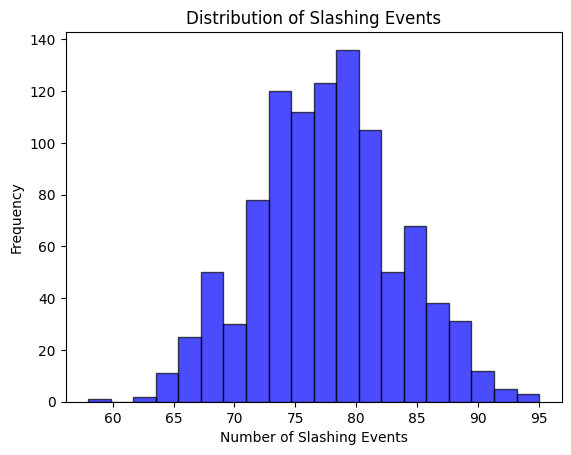

In [33]:
import numpy as np

num_simus = 1000
simu_results = []

num_validators = len(y_pred_prob)

for i in range(num_simus):
   sims_slashing = np.random.binomial(1, y_pred_prob)
   simu_results.append(sims_slashing.sum())

simu_results = np.array(simu_results)
expectation = simu_results.mean()
variance = simu_results.var()

print(f"Expected Slashing Events: {expectation}")

print(f"Variance of Slashing Events: {variance}")

#2 probability of at least one slashing event
prob_at_least_one = (simu_results > 0).mean()
print(f"Probability of at least one slashing event: {prob_at_least_one}")


#3 distribution of slashing events across validators
validator_slashed_counts = np.sum(simu_results, axis=0)

# Plot the distribution
plt.hist(simu_results, bins=20, alpha=0.7, color="blue", edgecolor="black")
plt.title("Distribution of Slashing Events")
plt.xlabel("Number of Slashing Events")
plt.ylabel("Frequency")
plt.show()




   

Mean Frequency (k): 77.311
Mean Severity: 2.269840615272029
Expected Total Loss: 175.10923816084366


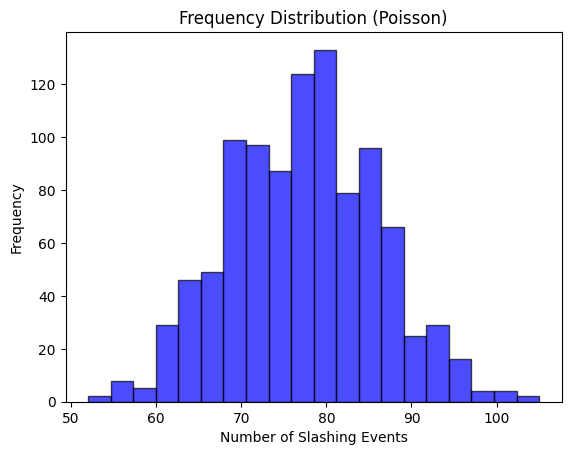

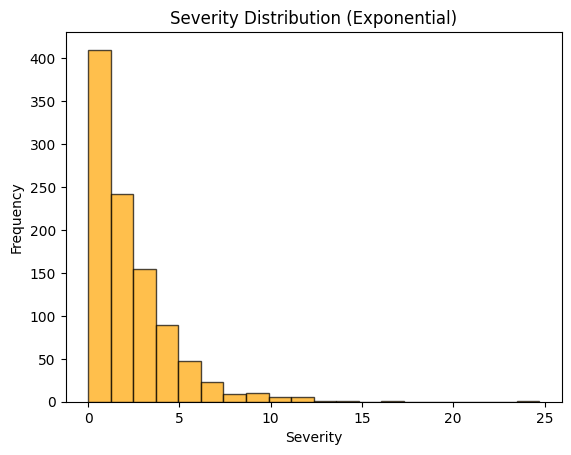

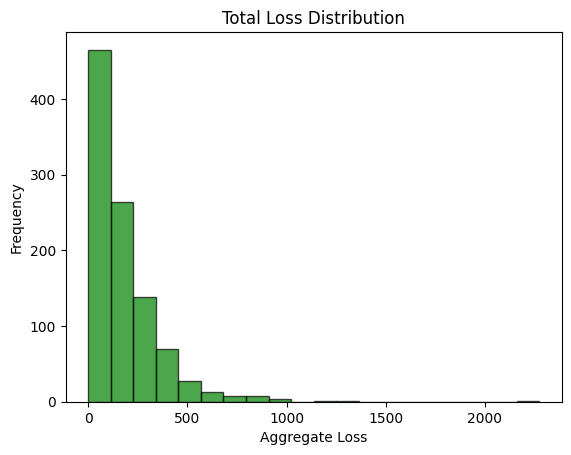

In [34]:
#Aggeregate Loss Model 

lambda_val = expectation
num_sims = 1000

# Severity lambda calculation using pseudo theory of expected value"ArithmeticError
# jailed offense times 0.01% * 8 tombstone events * 5 percent (from signing_data csv obs)

severity_lambda = (474 * 0.0001) + (8 * 0.05)

frequency_results = np.random.poisson(lam=lambda_val, size=num_sims)

severity_results = np.random.exponential(scale = 1 / severity_lambda, size=num_sims)

aggregate_loss = frequency_results * severity_results

print(f"Mean Frequency (k): {frequency_results.mean()}")
print(f"Mean Severity: {severity_results.mean()}")
print(f"Expected Total Loss: {aggregate_loss.mean()}")

# Plot Distributions
plt.hist(frequency_results, bins=20, alpha=0.7, color="blue", edgecolor="black")
plt.title("Frequency Distribution (Poisson)")
plt.xlabel("Number of Slashing Events")
plt.ylabel("Frequency")
plt.show()

plt.hist(severity_results, bins=20, alpha=0.7, color="orange", edgecolor="black")
plt.title("Severity Distribution (Exponential)")
plt.xlabel("Severity")
plt.ylabel("Frequency")
plt.show()

plt.hist(aggregate_loss, bins=20, alpha=0.7, color="green", edgecolor="black")
plt.title("Total Loss Distribution")
plt.xlabel("Aggregate Loss")
plt.ylabel("Frequency")
plt.show()


